<a href="https://colab.research.google.com/github/ebi19912/AI/blob/main/AutoEncoder_ConvNeXtBase_ChestClassification_wbce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d khanfashee/nih-chest-x-ray-14-224x224-resized

!unzip nih-chest-x-ray-14-224x224-resized.zip

Streaming output truncated to the last 5000 lines.
  inflating: images-224/images-224/00028897_017.png  
  inflating: images-224/images-224/00028897_018.png  
  inflating: images-224/images-224/00028897_019.png  
  inflating: images-224/images-224/00028897_020.png  
  inflating: images-224/images-224/00028898_000.png  
  inflating: images-224/images-224/00028899_000.png  
  inflating: images-224/images-224/00028899_001.png  
  inflating: images-224/images-224/00028899_002.png  
  inflating: images-224/images-224/00028900_000.png  
  inflating: images-224/images-224/00028901_000.png  
  inflating: images-224/images-224/00028901_001.png  
  inflating: images-224/images-224/00028902_000.png  
  inflating: images-224/images-224/00028902_001.png  
  inflating: images-224/images-224/00028902_002.png  
  inflating: images-224/images-224/00028902_003.png  
  inflating: images-224/images-224/00028902_004.png  
  inflating: images-224/images-224/00028902_005.png  
  inflating: images-224/images-

In [ ]:

import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ConvNeXtLarge
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, BatchNormalization
from tensorflow.keras.layers import AvgPool2D, MaxPool2D, ReLU, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score, confusion_matrix,
    matthews_corrcoef, average_precision_score, precision_recall_curve, roc_curve, roc_auc_score
)

from tensorflow.compat.v1.logging import INFO, set_verbosity
from tensorflow.python.framework.ops import disable_eager_execution
from matplotlib import rcParams
from keras.preprocessing import image


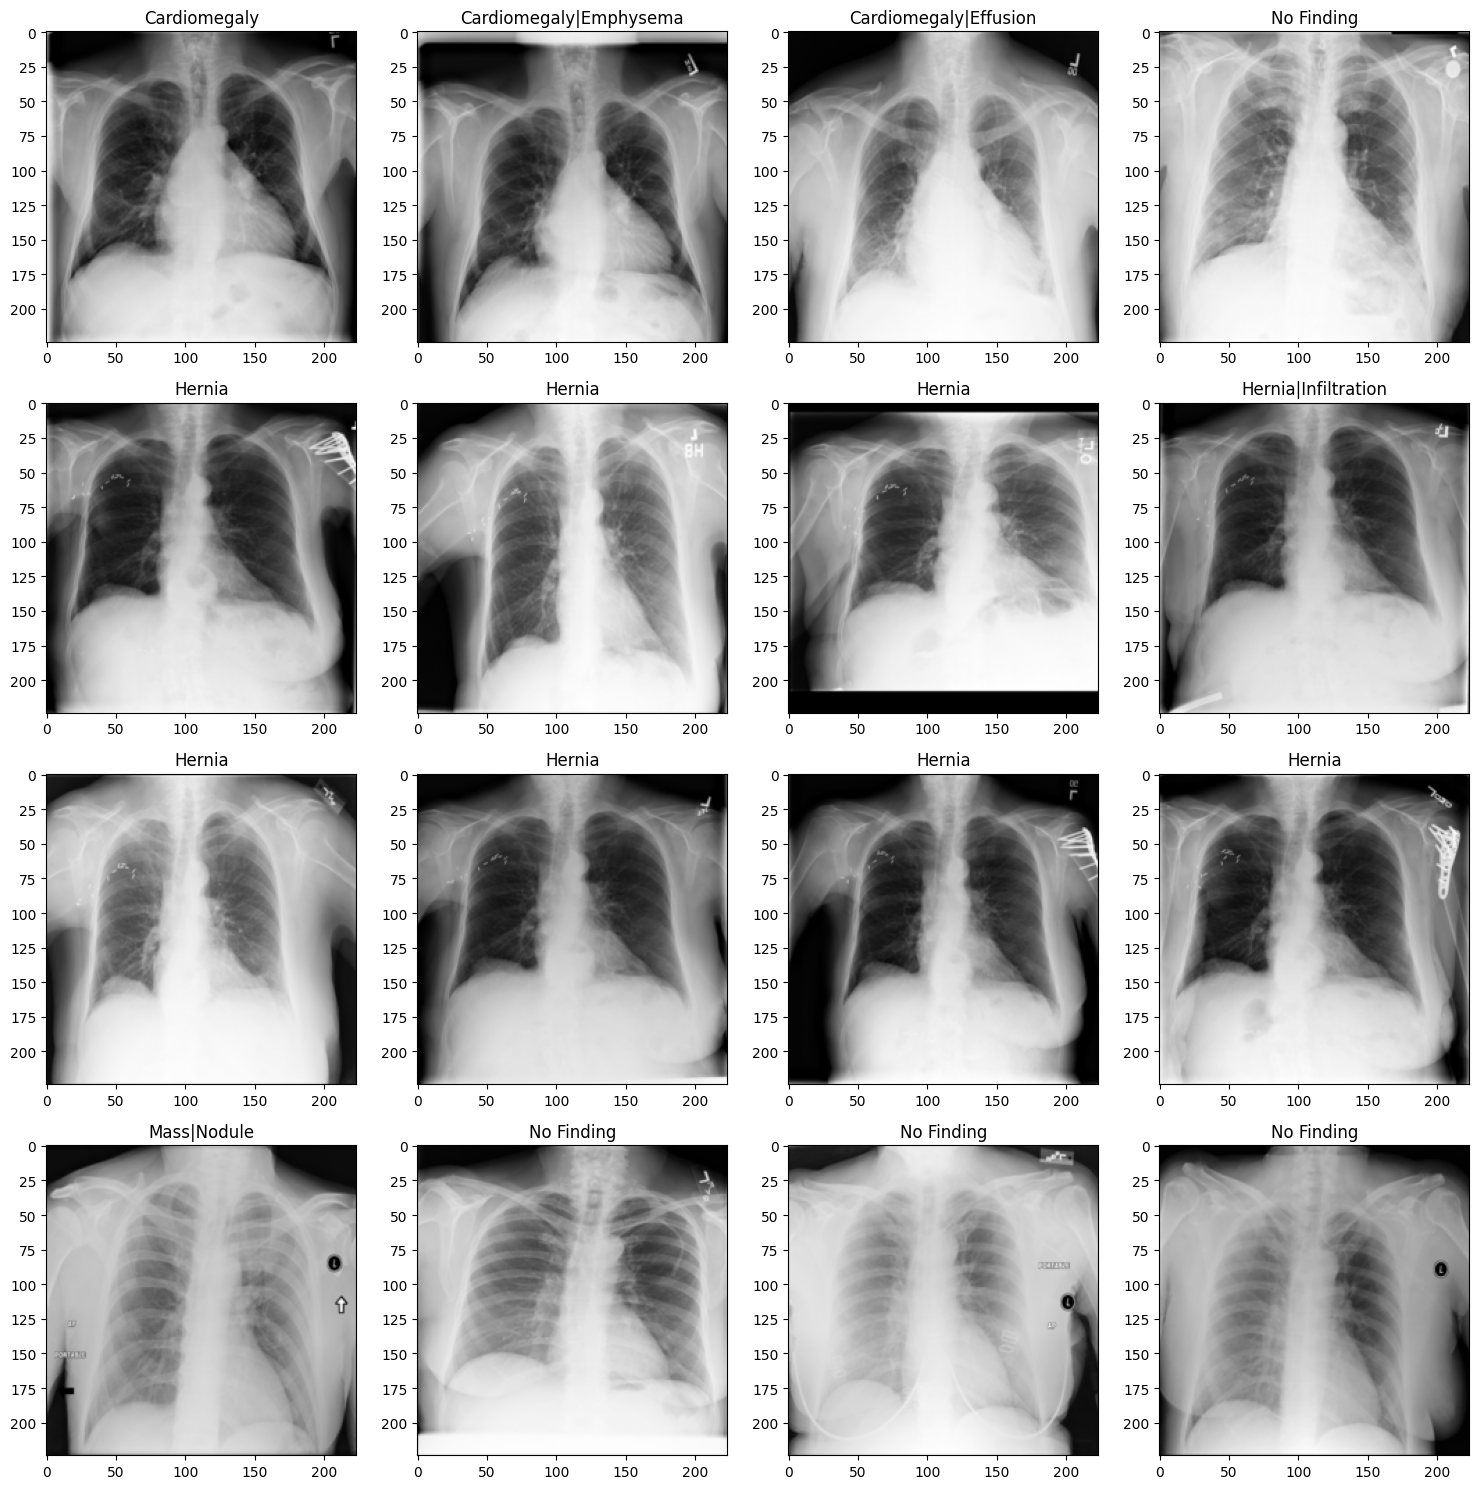

In [ ]:
dataframe = pd.read_csv("/content/Data_Entry_2017.csv")

#Enumerating all column names
columns = ["Image"]
for i in dataframe["Finding Labels"].values:
    for j in i.split("|"):
        if j not in columns:
            columns.append(j)
labels = columns.copy()
labels.remove("Image")

#Taking the first 20000 images from the master table as the train dataset
trainset = pd.DataFrame(columns = columns)
for i in range(20000):
    col = [0]*len(columns)
    col[0] = dataframe["Image Index"][i]
    count = 1
    for j in columns[1:]:
        if(j in dataframe["Finding Labels"][i]):
            col[count] = 1
        count+=1
    trainset.loc[len(trainset)] = col

#Taking the next 2000 images from the master table as the validation dataset
valset = pd.DataFrame(columns = columns)
for i in range(20000, 22000):
    col = [0]*len(columns)
    col[0] = dataframe["Image Index"][i]
    count = 1
    for j in columns[1:]:
        if(j in dataframe["Finding Labels"][i]):
            col[count] = 1
        count+=1
    valset.loc[len(valset)] = col

#Taking the next 2000 images from the master table as the test dataset
testset = pd.DataFrame(columns = columns)
for i in range(22000, 24000):
    col = [0]*len(columns)
    col[0] = dataframe["Image Index"][i]
    count = 1
    for j in columns[1:]:
        if(j in dataframe["Finding Labels"][i]):
            col[count] = 1
        count+=1
    testset.loc[len(testset)] = col

#Plotting first 16 images with their disease labels
img_dir = "/content/images-224/images-224"
plt.figure(figsize = (15,15))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(plt.imread(os.path.join(img_dir, trainset["Image"][i])), cmap = "gray")
    plt.title(dataframe[dataframe["Image Index"] == trainset["Image"][i]].values[0][1])
plt.tight_layout()

In [ ]:
def isOverlap(s1, s2):
    total = set(s1).intersection(set(s2))
    return [len(total), total]

def overlapcheck(trainset, valset, testset):
    patid_train = []
    patid_val = []
    patid_test = []
    for name in trainset['Image'].values:
        patid_train.append(int(name.split("_")[0]))

    for name in valset['Image'].values:
        patid_val.append(int(name.split("_")[0]))

    for name in testset['Image'].values:
        patid_test.append(int(name.split("_")[0]))
    trte = isOverlap(patid_train, patid_test)
    teva = isOverlap(patid_test, patid_val)
    trva = isOverlap(patid_train, patid_val)
    print("Patient Overlap - Train and Test: ", trte[0])
    print("Patient Overlap - Test and Validation: ", teva[0])
    print("Patient Overlap - Train and Validation: ", trva[0])
    return trte, teva, trva

#Checking for overlaps between trainset, testset and validation set
trte, teva, trva = overlapcheck(trainset, valset, testset)

#Removing overlapping patients
for i in trva[1]:
    for name in trainset['Image'].values:
        if(int(name.split("_")[0]) == i):
            trainset.drop(trainset.loc[trainset['Image'] == name].index, inplace=True)

#Checking for overlaps after removing common patients
trte, teva, trva = overlapcheck(trainset, valset, testset)

Patient Overlap - Train and Test:  0
Patient Overlap - Test and Validation:  0
Patient Overlap - Train and Validation:  1
Patient Overlap - Train and Test:  0
Patient Overlap - Test and Validation:  0
Patient Overlap - Train and Validation:  0


In [ ]:
def label_counts(df):
    label_counts = df[labels].sum().sort_values(ascending=False)
    return label_counts

print("Training Data Label Counts:")
print(label_counts(trainset))
print("\nValidation Data Label Counts:")
print(label_counts(valset))
print("\nTest Data Label Counts:")
print(label_counts(testset))

Training Data Label Counts:
No Finding            11720
Infiltration           2952
Effusion               1844
Atelectasis            1795
Nodule                  904
Pneumothorax            803
Consolidation           726
Cardiomegaly            692
Mass                    639
Pleural_Thickening      622
Fibrosis                467
Emphysema               382
Edema                   273
Pneumonia               225
Hernia                   53
dtype: int64

Validation Data Label Counts:
No Finding            1071
Infiltration           320
Atelectasis            224
Effusion               201
Nodule                 141
Pneumothorax            84
Mass                    78
Consolidation           78
Pleural_Thickening      59
Cardiomegaly            59
Emphysema               57
Fibrosis                41
Edema                   30
Pneumonia               25
Hernia                   1
dtype: int64

Test Data Label Counts:
No Finding            1213
Infiltration           313
Effusion   

Maximum Pixel Value:  0.8980392
Minimum Pixel Value:  0.019607844
Image dimension: 224 x 224 
Mean - Pixel Value:  0.5310754
Std Deviation Pixel Value:  0.18286845


<Axes: xlabel='Pixel Values', ylabel='Count'>

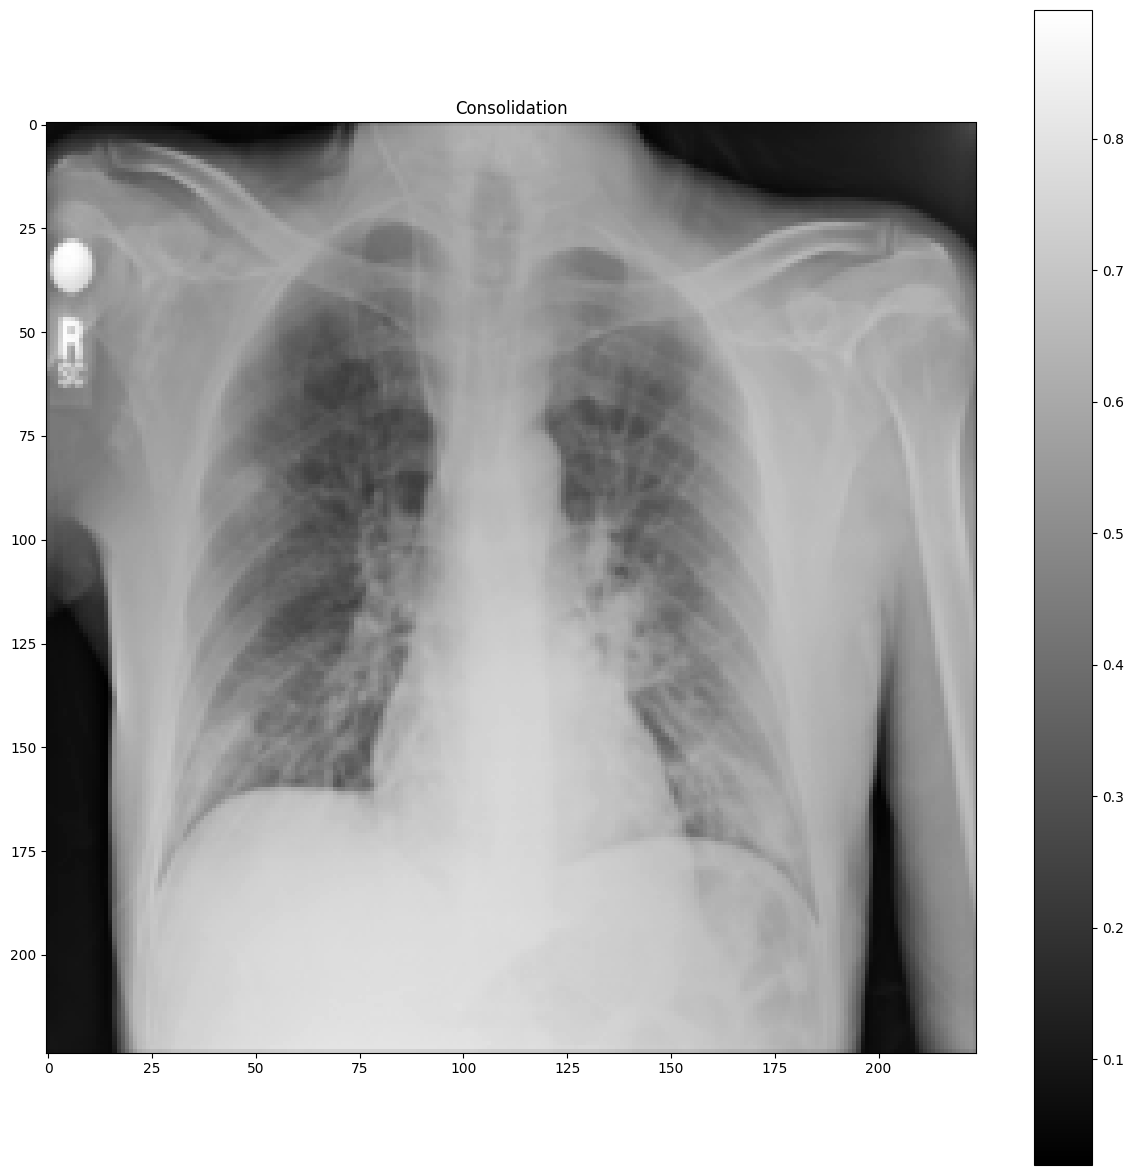

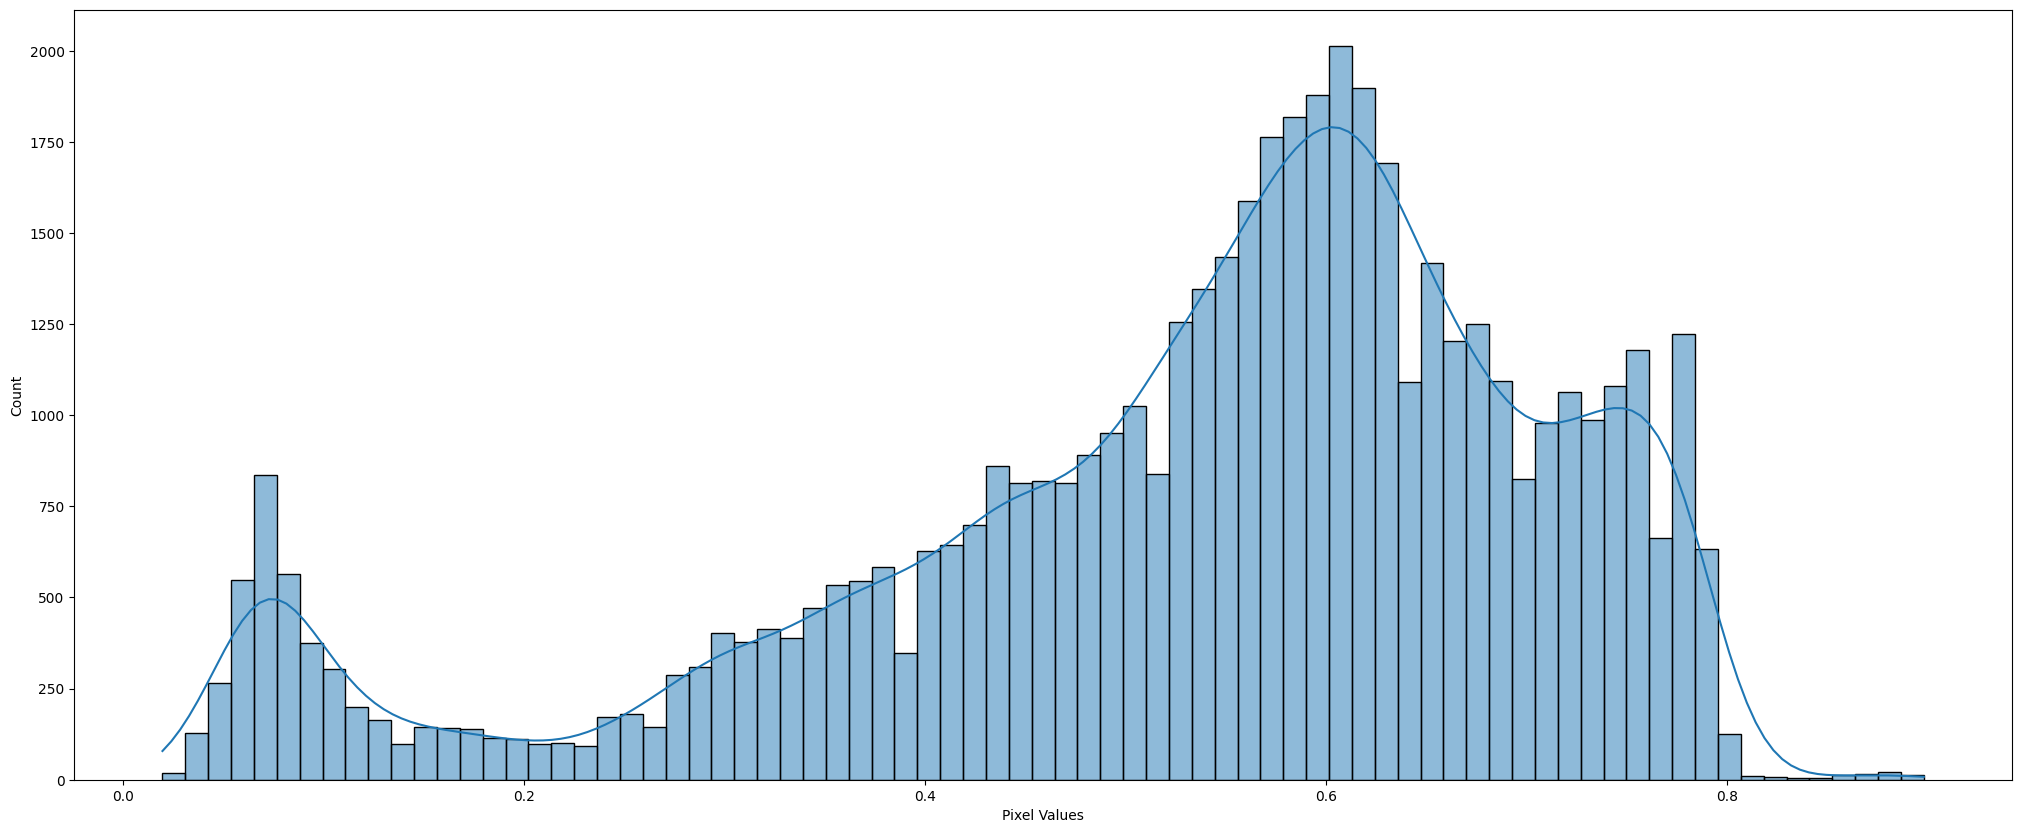

In [ ]:
num = np.random.randint(trainset.shape[0])
sample = plt.imread(os.path.join(img_dir,trainset.iloc[[num]]["Image"].values[0]))
plt.figure(figsize=(15, 15))
plt.title(dataframe[dataframe["Image Index"] == trainset.iloc[[num]]["Image"].values[0]].values[0][1])
plt.imshow(sample, cmap = 'gray')
plt.colorbar()
trainset.iloc[[num]]

print("Maximum Pixel Value: ", sample.max())
print("Minimum Pixel Value: ", sample.min())
print(f"Image dimension: {sample.shape[0]} x {sample.shape[1]} ")

fig, ax = plt.subplots(figsize=(25, 10))
plt.xlabel("Pixel Values")
print("Mean - Pixel Value: ", sample.mean())
print("Std Deviation Pixel Value: ", sample.std())
sns.histplot(sample.ravel(), ax = ax, kde = True)

Found 19989 validated image filenames.
Found 19989 validated image filenames.
Found 2000 validated image filenames.
Found 2000 validated image filenames.


Mean of Pixel Values - Standardized:  -2.4652806e-07
Standard Deviation of Pixel Values - Standardized:  0.99999994
Mean of Pixel Values - Sample:  0.5310754
Standard Deviation of Pixel Values - Sample:  0.18286845


<Axes: xlabel='Pixel Values', ylabel='Count'>

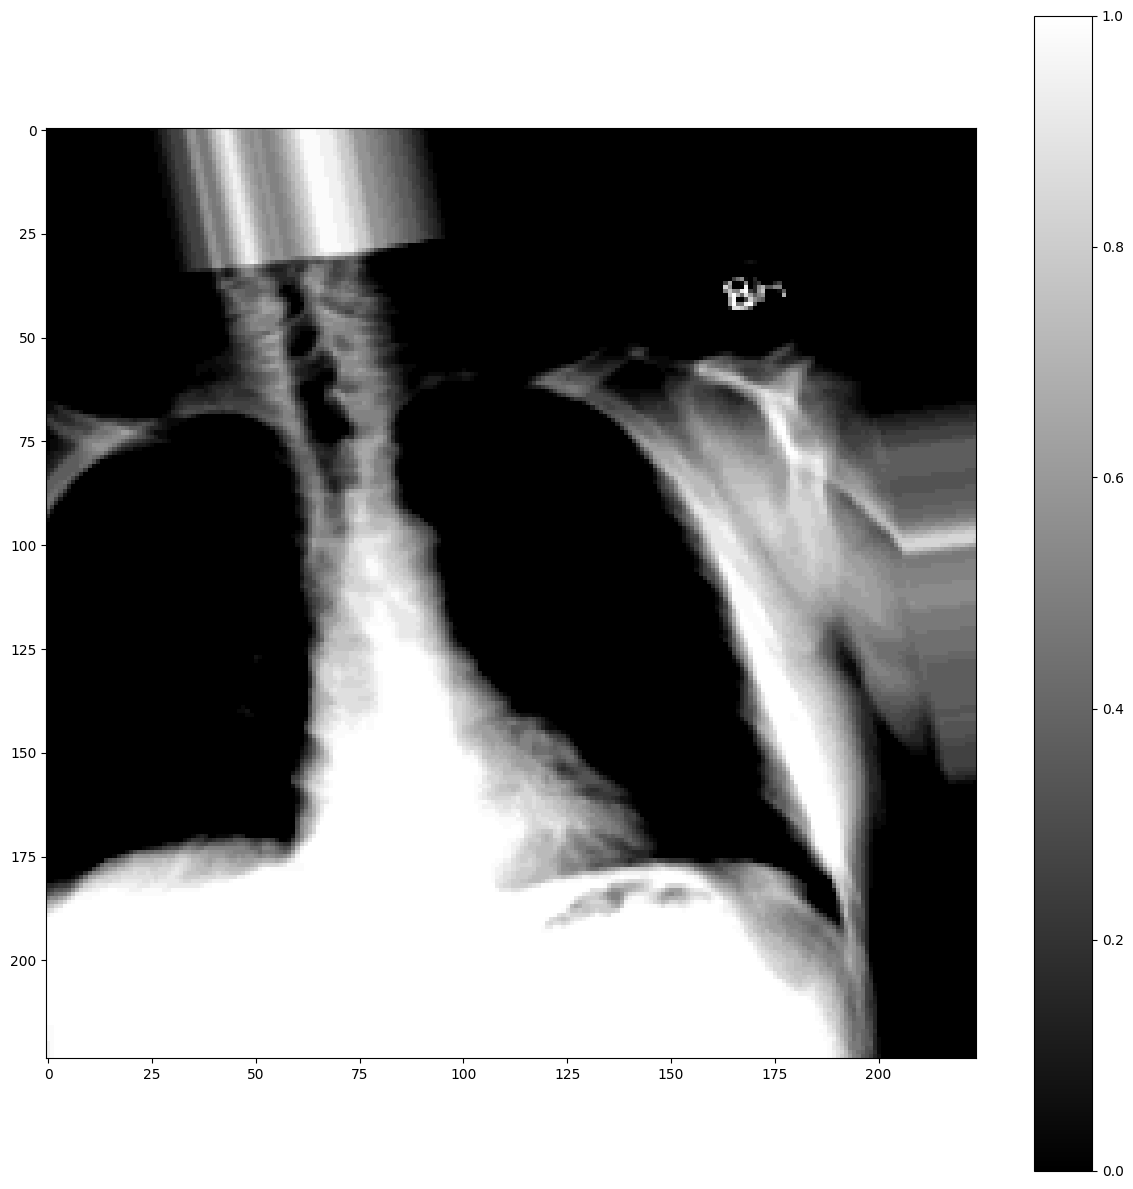

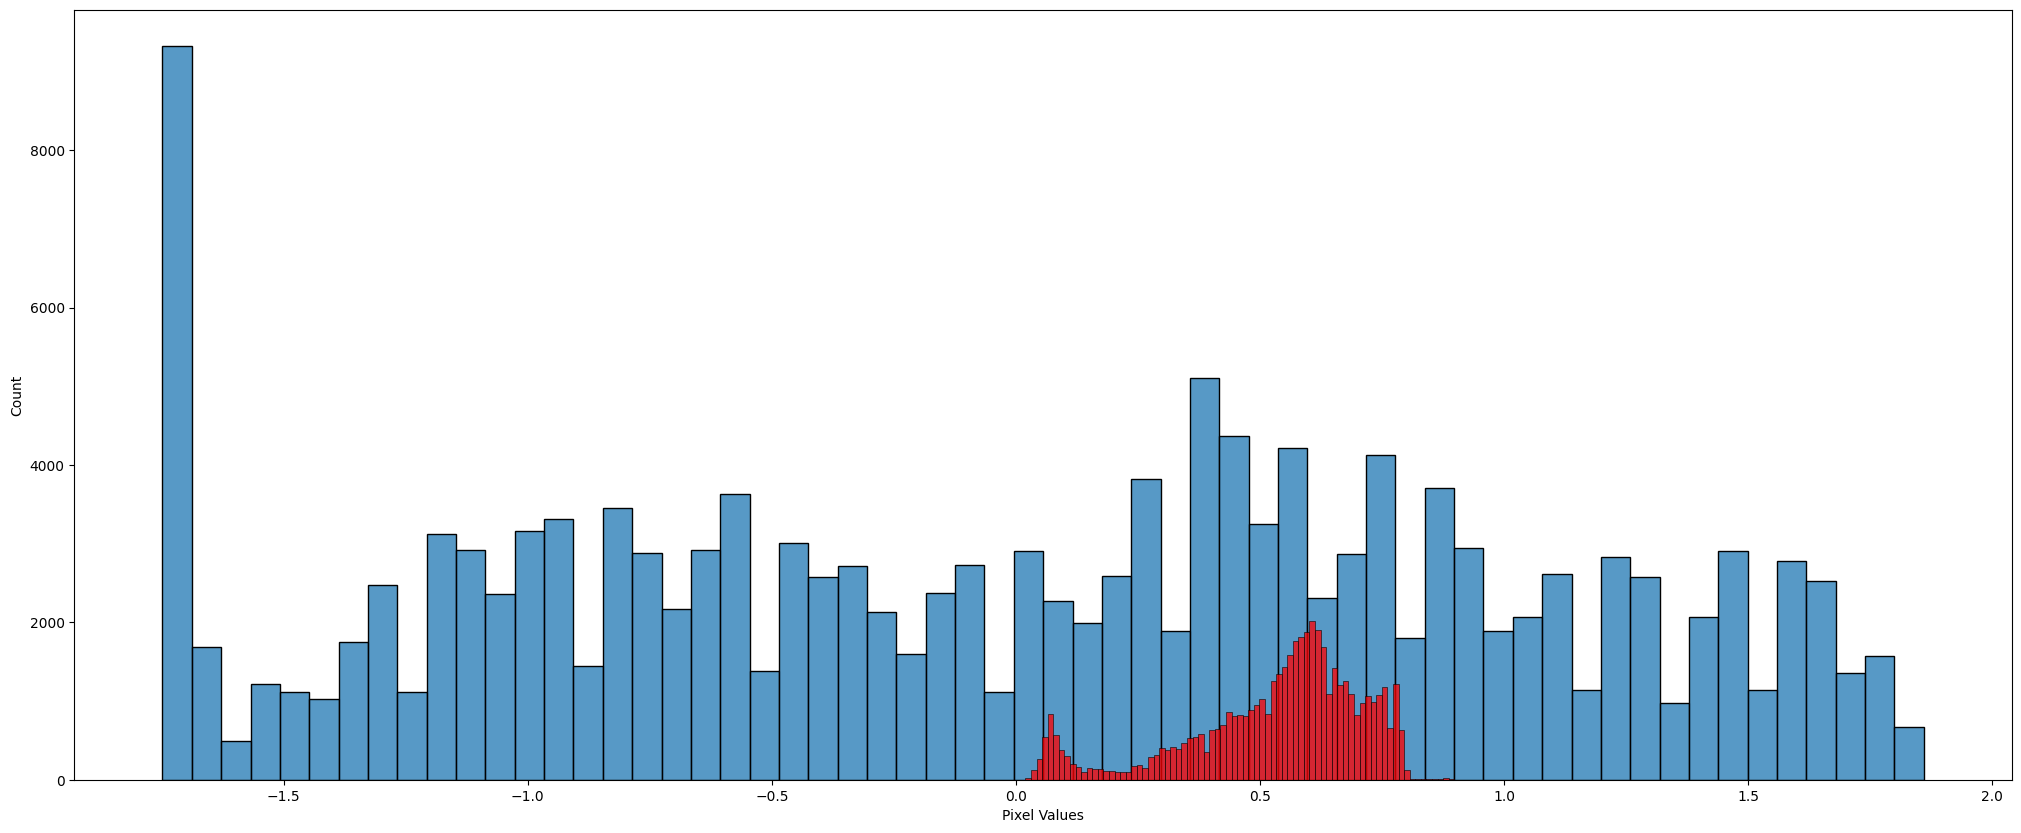

In [ ]:
def adjust_contrast_and_saturation(image):
  # Generate a random contrast factor between 0.4 and 0.9
  contrast_factor = tf.random.uniform([], 0.4, 0.9)
  image = tf.image.adjust_contrast(image, contrast_factor)

  # Generate a random saturation factor between 0.4 and 0.9
  saturation_factor = tf.random.uniform([], 0.4, 0.9)
  image = tf.image.adjust_saturation(image, saturation_factor)

  return image

traingen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    brightness_range=[0.3, 1.2],
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    preprocessing_function=adjust_contrast_and_saturation
)
img_dir = "/content/images-224/images-224"
bach=8
traingenerator = traingen.flow_from_dataframe(
        dataframe=trainset,
        directory=img_dir,
        x_col="Image",
        y_col= labels,
        class_mode="raw",
        batch_size= bach,
        shuffle=False,
        target_size=(224,224)
)
#Standardizing featurewise as we don't process images as groups rather one-by-one
imagegen = ImageDataGenerator().flow_from_dataframe(dataframe = trainset,
                                                    directory = img_dir,
                                                    x_col = "Image",
                                                    y_col = labels, class_mode = "raw",
                                                    batch_size= bach,
                                                    shuffle=False,
                                                    target_size=(224,224))
train_sample = next(imagegen)[0]
imagegen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization= True)
imagegen.fit(train_sample)
valgenerator = imagegen.flow_from_dataframe(dataframe = valset,
                                            directory = img_dir,
                                            x_col = "Image",
                                            y_col = labels,
                                            class_mode = "raw",
                                            batch_size= bach,
                                            shuffle=False,
                                            target_size=(224,224))
testgenerator = imagegen.flow_from_dataframe(dataframe = testset,
                                             directory = img_dir,
                                             x_col = "Image",
                                             y_col = labels,
                                             class_mode = "raw",
                                             batch_size= bach,
                                             shuffle=False,
                                             target_size=(224,224))


#Taking a random sample standardized image
num = np.random.randint(len(traingenerator))

item, value = traingenerator.__getitem__(num)
plt.figure(figsize=(15, 15))
plt.imshow(item[0], cmap = 'gray')
plt.colorbar()

#Plotting the histogram of original and standardized pixel intensities
fig, ax = plt.subplots(figsize=(25, 10))
plt.xlabel("Pixel Values")
print("Mean of Pixel Values - Standardized: ", item[0].mean())
print("Standard Deviation of Pixel Values - Standardized: ", item[0].std())
print("Mean of Pixel Values - Sample: ", sample.mean())
print("Standard Deviation of Pixel Values - Sample: ", sample.std())
sns.histplot(item[0].ravel(), ax = ax, kde = False)
sns.histplot(sample.ravel(), ax = ax, kde = False, color = "red")

<Figure size 2000x1500 with 0 Axes>

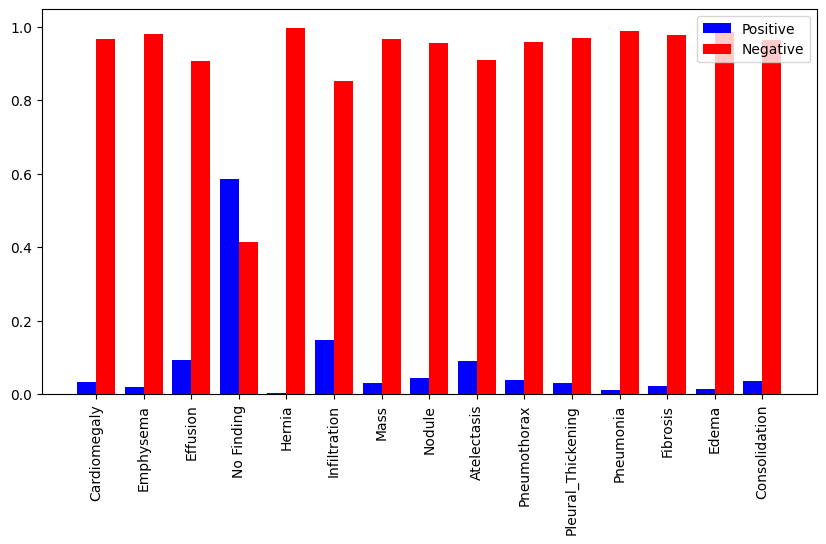

<Figure size 2000x1500 with 0 Axes>

In [ ]:
# Calculate positive and negative frequencies for each label
positive_freqs = trainset[labels].sum().values / trainset.shape[0]  # Assuming labels are 1 for positive, 0 for negative
negative_freqs = 1 - positive_freqs

data = {
    'Class': labels,
    'Positive': positive_freqs, #* negative_freqs, #Removed
    'Negative': negative_freqs #* positive_freqs #Removed
}

X_axis = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(X_axis-0.2, data['Positive'], width=0.4, color='b', label = "Positive")
ax.bar(X_axis+0.2, data['Negative'], width=0.4, color='r', label = 'Negative')
plt.xticks(X_axis, labels, rotation = 90)
plt.legend()
plt.figure(figsize=(20,15))

In [ ]:
# Assuming you have your labels and save directory defined

save_dir = '/content/drive/My Drive/saved_models/'
os.makedirs(save_dir, exist_ok=True)

# Define a function to create the model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, concatenate, Flatten, Lambda
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import ConvNeXtBase
import tensorflow as tf
import os
def create_model():
    # Load pretrained encoder
    encoder = load_model('/content/encoder_model.keras', compile=False)
    for layer in encoder.layers:
        layer.trainable = False

    # Input
    input_tensor = Input(shape=(224, 224, 3), name='input_rgb')

    # Encoder branch (grayscale + resize to match encoder input)
    encoder_input = Lambda(lambda x: tf.image.resize(tf.reduce_mean(x, axis=-1, keepdims=True), (128, 128)),
                           name='rgb_to_gray_resize')(input_tensor)
    encoder_output = encoder(encoder_input)
    encoder_flat = Flatten(name='encoder_flat')(encoder_output)

    # ConvNeXtBase branch
    vgg_base = ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in vgg_base.layers:
        layer.trainable = False

    vgg_feat = vgg_base(input_tensor)
    vgg_gap = GlobalAveragePooling2D(name='vgg_gap')(vgg_feat)
    vgg_dense = Dense(256, activation='relu', name='vgg_dense')(vgg_gap)

    # Merge both features
    merged = concatenate([encoder_flat, vgg_dense], name='concat_features')

    # Dense classifier
    x = Dense(512, activation='relu', name='dense1')(merged)
    x = Dense(256, activation='relu', name='dense2')(x)
    output = Dense(len(labels), activation='sigmoid', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)
    return model



model = create_model()
model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_rgb           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rgb_to_gray_resize  │ (None, 128, 128,  │          0 │ input_rgb[0][0]   │
│ (Lambda)            │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg19 (Functional)  │ (None, 7, 7, 512) │ 20,024,384 │ input_rgb[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 16, 16,    │     92,672 │ rgb_to_gray_resi… │
│ (Functional)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg_gap             │ (None, 512)       │          0 │ vgg19[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_flat        │ (None, 32768)     │          0 │ encoder[0][0]     │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg_dense (Dense)   │ (None, 256)       │    131,328 │ vgg_gap[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_features     │ (None, 33024)     │          0 │ encoder_flat[0][… │
│ (Concatenate)       │                   │            │ vgg_dense[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 512)       │ 16,908,800 │ concat_features[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 256)       │    131,328 │ dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 15)        │      3,855 │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 37,292,367 (142.26 MB)

 Trainable params: 17,175,311 (65.52 MB)

 Non-trainable params: 20,117,056 (76.74 MB)

In [ ]:
def weighted_cross_entropy(y_true, y_pred):
    # Calculate positive and negative weights based on class frequencies in your dataset.
    positive_weights = tf.constant(positive_freqs, dtype=tf.float32)  # Example positive weights
    negative_weights = tf.constant(negative_freqs, dtype=tf.float32)  # Example negative weights

    # Calculate the weighted loss
    loss = -(y_true * tf.math.log(y_pred + 1e-7) * positive_weights + (1 - y_true) * tf.math.log(1 - y_pred + 1e-7) * negative_weights)

    return tf.reduce_mean(loss)

In [ ]:
# Function to train the model and save it
def train_and_save_model(model_name):
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-5), loss=weighted_cross_entropy, metrics=['accuracy'])

    # Define callbacks
    checkpoint = ModelCheckpoint(f'{model_name}.keras',
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(
        traingenerator,
        epochs=100,
        validation_data=valgenerator,
        callbacks=[checkpoint, early_stopping]
    )

    return history

# Train the model and save it
history = train_and_save_model('ConvNeXtBase_Autoencoder_chest_xray_ensemble')

Epoch 1/100
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.5935 - loss: 0.0401
Epoch 1: val_loss improved from inf to 0.04581, saving model to VGG19_Autoencoder_chest_xray_ensemble.keras
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 510s 203ms/step - accuracy: 0.5935 - loss: 0.0401 - val_accuracy: 0.5355 - val_loss: 0.0458
Epoch 2/100
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.5815 - loss: 0.0392
Epoch 2: val_loss improved from 0.04581 to 0.04525, saving model to VGG19_Autoencoder_chest_xray_ensemble.keras
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 500s 200ms/step - accuracy: 0.5815 - loss: 0.0392 - val_accuracy: 0.5355 - val_loss: 0.0453
Epoch 3/100
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.5841 - loss: 0.0389
Epoch 3: val_loss did not improve from 0.04525
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 486s 195ms/step - accuracy: 0.5841 - loss: 0.0389 - val_accuracy: 0.5355 - val_loss: 0.0454
Epoch 4/100
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.5826 - loss: 0.0387


250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step
Best threshold for Cardiomegaly: 0.006
Confusion Matrix for Cardiomegaly (Threshold: 0.006):
[[1440  535]
 [  17    8]]
Specificity for Cardiomegaly: 0.7291139240506329
Best threshold for Emphysema: 0.011
Confusion Matrix for Emphysema (Threshold: 0.011):
[[1926   51]
 [  21    2]]
Specificity for Emphysema: 0.9742033383915023
Best threshold for Effusion: 0.038400000000000004
Confusion Matrix for Effusion (Threshold: 0.038400000000000004):
[[1535  267]
 [ 149   49]]
Specificity for Effusion: 0.8518312985571587
Best threshold for No Finding: 0.0001
Confusion Matrix for No Finding (Threshold: 0.0001):
[[   0  787]
 [   0 1213]]
Specificity for No Finding: 0.0
Best threshold for Hernia: 0.0001
Confusion Matrix for Hernia (Threshold: 0.0001):
[[1021  977]
 [   2    0]]
Specificity for Hernia: 0.511011011011011
Best threshold for Infiltration: 0.005600000000000001
Confusion Matrix for Infiltration (Threshold: 0.005600000000000001):
[[ 143 1544]
 [ 

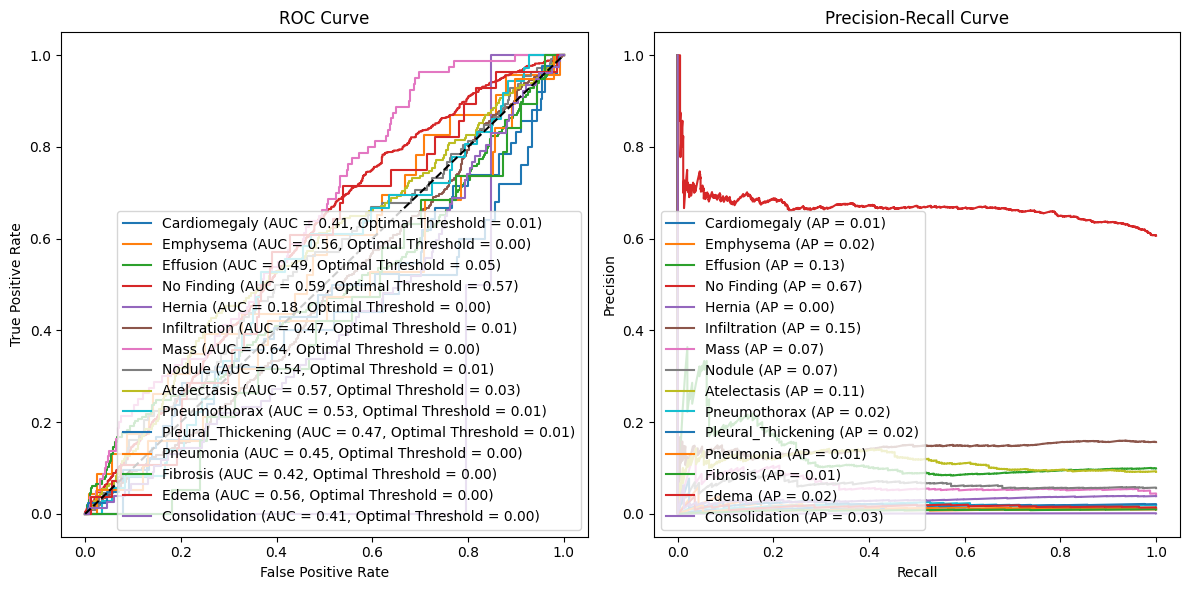

In [ ]:
# Initialize lists to store evaluation metrics for each label
precision_list = []
recall_list = []
f1_list = []
accuracy_list = []
mcc_list = []
auc_pr_list = []
best_thresholds = []
predicted_vals = model.predict(testgenerator)
# Iterate through labels and calculate metrics
for i in range(len(labels)):
    try:
        gt = np.array(testgenerator.labels[:, i])
        pred_probs = predicted_vals[:, i]

        # Find optimal threshold based on F1-score
        best_f1 = -1
        best_thresh = 0
        for thresh in np.arange(0.0001, 0.0999999, 0.0001):  # Iterate through different thresholds
            pred = (pred_probs > thresh).astype(int)
            f1 = f1_score(gt, pred)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh

        best_thresholds.append(best_thresh)
        print(f"Best threshold for {labels[i]}: {best_thresh}")

        # Use the best threshold for evaluation
        pred = (pred_probs > best_thresh).astype(int)

        precision = precision_score(gt, pred)
        recall = recall_score(gt, pred)
        f1 = f1_score(gt, pred)
        accuracy = accuracy_score(gt, pred)
        mcc = matthews_corrcoef(gt, pred)
        auc_pr = average_precision_score(gt, pred_probs)

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        accuracy_list.append(accuracy)
        mcc_list.append(mcc)
        auc_pr_list.append(auc_pr)

        # Calculate Confusion Matrix
        cm = confusion_matrix(gt, pred)
        print(f"Confusion Matrix for {labels[i]} (Threshold: {best_thresh}):")
        print(cm)
        # Calculate Specificity
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp)
        print(f"Specificity for {labels[i]}: {specificity}")

    except ValueError:
        pass


# Store the metrics in a DataFrame for better presentation
metrics_df = pd.DataFrame({
    'Label': labels,
    'Best Threshold': best_thresholds,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1-Score': f1_list,
    'Accuracy': accuracy_list,
    'MCC': mcc_list,
    'AUC-PR': auc_pr_list
})

print(metrics_df)

# Plot ROC and PR curves for each label in one plot
plt.figure(figsize=(12, 6))

# ROC curve
plt.subplot(1, 2, 1)
for i in range(len(labels)):
    try:
        gt = np.array(testgenerator.labels[:, i])
        pred = predicted_vals[:, i]
        fpr, tpr, thresholds = roc_curve(gt, pred)

        # Calculate Youden's J for each threshold
        youden_j = tpr - fpr

        # Find the optimal threshold based on Youden's J
        optimal_idx = np.argmax(youden_j)
        optimal_threshold = thresholds[optimal_idx]

        roc_auc = roc_auc_score(gt, pred)
        plt.plot(fpr, tpr, label=f"{labels[i]} (AUC = {roc_auc:.2f}, Optimal Threshold = {optimal_threshold:.2f})")
    except ValueError:
        pass
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# PR curve
plt.subplot(1, 2, 2)
for i in range(len(labels)):
    try:
        gt = np.array(testgenerator.labels[:, i])
        pred = predicted_vals[:, i]
        precision, recall, _ = precision_recall_curve(gt, pred)
        average_precision = average_precision_score(gt, pred)
        plt.plot(recall, precision, label=f"{labels[i]} (AP = {average_precision:.2f})")
    except ValueError:
        pass
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step
Best threshold for Cardiomegaly: 0.049100000000000005
Confusion Matrix for Cardiomegaly (Threshold: 0.049100000000000005):
[[1975    0]
 [  25    0]]
Specificity for Cardiomegaly: 1.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best threshold for Emphysema: 0.0437
Confusion Matrix for Emphysema (Threshold: 0.0437):
[[1977    0]
 [  23    0]]
Specificity for Emphysema: 1.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best threshold for Effusion: 0.0679
Confusion Matrix for Effusion (Threshold: 0.0679):
[[1778   24]
 [ 186   12]]
Specificity for Effusion: 0.9866814650388457
Best threshold for No Finding: 0.0001
Confusion Matrix for No Finding (Threshold: 0.0001):
[[   0  787]
 [   0 1213]]
Specificity for No Finding: 0.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best threshold for Hernia: 0.01
Confusion Matrix for Hernia (Threshold: 0.01):
[[1998    0]
 [   2    0]]
Specificity for Hernia: 1.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best threshold for Infiltration: 0.09970000000000001
Confusion Matrix for Infiltration (Threshold: 0.09970000000000001):
[[1534  153]
 [ 287   26]]
Specificity for Infiltration: 0.9093064611736811
Best threshold for Mass: 0.0654
Confusion Matrix for Mass (Threshold: 0.0654):
[[1920    0]
 [  80    0]]
Specificity for Mass: 1.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best threshold for Nodule: 0.09240000000000001
Confusion Matrix for Nodule (Threshold: 0.09240000000000001):
[[1888    0]
 [ 112    0]]
Specificity for Nodule: 1.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best threshold for Atelectasis: 0.0979
Confusion Matrix for Atelectasis (Threshold: 0.0979):
[[1816    1]
 [ 183    0]]
Specificity for Atelectasis: 0.9994496422674739
Best threshold for Pneumothorax: 0.0829
Confusion Matrix for Pneumothorax (Threshold: 0.0829):
[[1964    0]
 [  36    0]]
Specificity for Pneumothorax: 1.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best threshold for Pleural_Thickening: 0.07360000000000001
Confusion Matrix for Pleural_Thickening (Threshold: 0.07360000000000001):
[[1958    0]
 [  42    0]]
Specificity for Pleural_Thickening: 1.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best threshold for Pneumonia: 0.033600000000000005
Confusion Matrix for Pneumonia (Threshold: 0.033600000000000005):
[[1981    0]
 [  19    0]]
Specificity for Pneumonia: 1.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best threshold for Fibrosis: 0.0478
Confusion Matrix for Fibrosis (Threshold: 0.0478):
[[1981    0]
 [  19    0]]
Specificity for Fibrosis: 1.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best threshold for Edema: 0.0369
Confusion Matrix for Edema (Threshold: 0.0369):
[[1972    0]
 [  28    0]]
Specificity for Edema: 1.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best threshold for Consolidation: 0.060000000000000005
Confusion Matrix for Consolidation (Threshold: 0.060000000000000005):
[[1923    0]
 [  77    0]]
Specificity for Consolidation: 1.0
                 Label  Best Threshold  Weighted Precision  Weighted Recall  \
0         Cardiomegaly          0.0491            0.975156           0.9875   
1            Emphysema          0.0437            0.977132           0.9885   
2             Effusion          0.0679            0.848671           0.8950   
3           No Finding          0.0001            0.367842           0.6065   
4               Hernia          0.0100            0.998001           0.9990   
5         Infiltration          0.0997            0.733291           0.7800   
6                 Mass          0.0654            0.921600           0.9600   
7               Nodule          0.0924            0.891136           0.9440   
8          Atelectasis          0.0979            0.825331           0.9080   
9         Pneumothorax 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


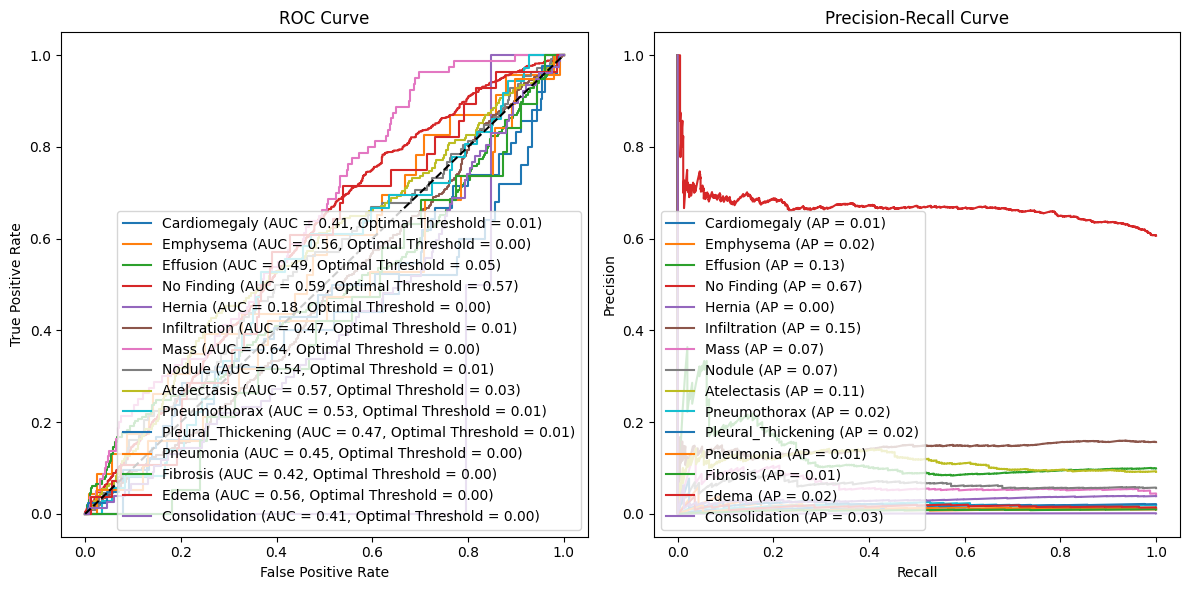

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score,
                             matthews_corrcoef, average_precision_score, confusion_matrix,
                             roc_curve, roc_auc_score, precision_recall_curve)

weighted_precision_list = []
weighted_recall_list = []
weighted_f1_list = []
accuracy_list = []
mcc_list = []
auc_pr_list = []
best_thresholds = []

predicted_vals = model.predict(testgenerator)
all_gt = np.array(testgenerator.labels)
all_pred_probs = predicted_vals

for i in range(len(labels)):
    try:
        gt = all_gt[:, i]
        pred_probs = all_pred_probs[:, i]

        best_f1 = -1
        best_thresh = 0
        for thresh in np.arange(0.0001, 0.0999999, 0.0001):
            pred = (pred_probs > thresh).astype(int)
            f1 = f1_score(gt, pred, average="weighted")
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh

        best_thresholds.append(best_thresh)
        print(f"Best threshold for {labels[i]}: {best_thresh}")

        pred = (pred_probs > best_thresh).astype(int)

        weighted_precision = precision_score(gt, pred, average="weighted")
        weighted_recall = recall_score(gt, pred, average="weighted")
        weighted_f1 = f1_score(gt, pred, average="weighted")
        accuracy = accuracy_score(gt, pred)
        mcc = matthews_corrcoef(gt, pred)
        auc_pr = average_precision_score(gt, pred_probs)

        weighted_precision_list.append(weighted_precision)
        weighted_recall_list.append(weighted_recall)
        weighted_f1_list.append(weighted_f1)
        accuracy_list.append(accuracy)
        mcc_list.append(mcc)
        auc_pr_list.append(auc_pr)

        cm = confusion_matrix(gt, pred)
        print(f"Confusion Matrix for {labels[i]} (Threshold: {best_thresh}):")
        print(cm)

        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            print(f"Specificity for {labels[i]}: {specificity}")

    except ValueError:
        pass

metrics_df = pd.DataFrame({
    'Label': labels,
    'Best Threshold': best_thresholds,
    'Weighted Precision': weighted_precision_list,
    'Weighted Recall': weighted_recall_list,
    'Weighted F1-Score': weighted_f1_list,
    'Accuracy': accuracy_list,
    'MCC': mcc_list,
    'AUC-PR': auc_pr_list
})

print(metrics_df)

print("\nOverall Weighted Metrics:")
print(f"Mean Weighted Precision: {np.mean(weighted_precision_list):.4f}")
print(f"Mean Weighted Recall: {np.mean(weighted_recall_list):.4f}")
print(f"Mean Weighted F1-Score: {np.mean(weighted_f1_list):.4f}")
print(f"Mean Accuracy: {np.mean(accuracy_list):.4f}")
print(f"Mean MCC: {np.mean(mcc_list):.4f}")
print(f"Mean AUC-PR: {np.mean(auc_pr_list):.4f}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for i in range(len(labels)):
    try:
        gt = all_gt[:, i]
        pred = all_pred_probs[:, i]
        fpr, tpr, thresholds = roc_curve(gt, pred)

        youden_j = tpr - fpr
        optimal_idx = np.argmax(youden_j)
        optimal_threshold = thresholds[optimal_idx]

        roc_auc = roc_auc_score(gt, pred)
        plt.plot(fpr, tpr, label=f"{labels[i]} (AUC = {roc_auc:.2f}, Optimal Threshold = {optimal_threshold:.2f})")
    except ValueError:
        pass
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
for i in range(len(labels)):
    try:
        gt = all_gt[:, i]
        pred = all_pred_probs[:, i]
        precision, recall, _ = precision_recall_curve(gt, pred)
        average_precision = average_precision_score(gt, pred)
        plt.plot(recall, precision, label=f"{labels[i]} (AP = {average_precision:.2f})")
    except ValueError:
        pass
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()
